In [1]:
import sys; sys.path.append("../src2")
from pendulum import *
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import newton

In [ ]:
class srinivasan(object):
    
    def __init__(self, kx, kv, kt, kw, um):
        
        # gains
        self.kx = kx
        self.kv = kv
        self.kt = kt
        self.kw = kw
        
        # max input
        self.um = um
        
        # initial reference angle
        self.tr = 0
        
        # theta tildes
        self.ttl = np.array([newton(lambda tt: self.eq_tt(tt, tr), 4*np.pi) for tr in [-2*np.pi, 0, 2*np.pi]])
        print(self.ttl)
        
    def eq_tt(self, tt, tr):
        xm = np.pi**2*(np.pi+self.um)
        vm = np.pi*self.um
        return self.kt*(tt-tr) + np.sin(tt) + self.kt*np.arctan(self.kx*xm + self.kv*vm) - self.um*np.cos(tt)
    
    def gen_tt(self, tr):
        if tr == -2*np.pi:
            tt = self.ttl[0]
        elif tr == 0:
            tt = self.ttl[1]
        elif tr == 2*np.pi:
            tt = self.ttl[2]
        return tt
        
    def gen_tr(self, t, tr):
        dt = t - tr
        tt = self.gen_tt(tr)
        if -np.pi <= dt and dt < -tt:
            return tr - 2*np.pi
        elif -tt <= dt and dt <= tt:
            return tr
        elif tt < dt and np.pi:
            return tr + 2*np.pi
        
    def gen_u(self, state, tr):
        x, v, t, w = state
        uus = self.kt*(t-tr) + self.kw*w + np.sin(t) + self.kt*np.arctan(self.kx*x + self.kv*v)
        u = np.clip(uus, -self.um, self.um)
        return u
    
    def __call__(self, time, state):
        return self.gen_u(state, self.tr)
    
    def control(self, time, state):
        x, v, t, w = state
        u = self.gen_u(state, self.tr)
        self.tr = self.gen_tr(t, self.tr)
        return u
        

In [38]:
cont = srinivasan(0.1, 0.3, 10, 8, 1.5)
#cont.tr = -2*np.pi

In [39]:
x0 = [0,0,np.pi,0]
xf = np.array([0,0,0,0])
dyn  = dynamics(x0,xf, 0)

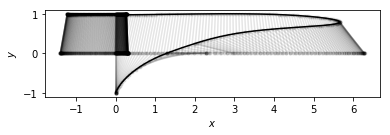

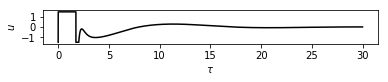

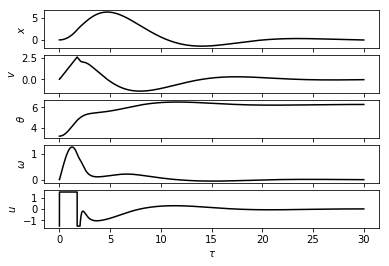

In [40]:
t, x, u = dyn.propagate_controlled(30, cont)
plot_traj(x, arm=True, n=500)
ax = plot_controls(t, u)
ax = plot_states(t, x, u)

In [41]:
xn = np.copy(x)
xn[:,2] = x[:,2] - 2*np.pi
n = np.argwhere(np.linalg.norm(xn, axis=1) < 0.2)[0][0]
n

2080

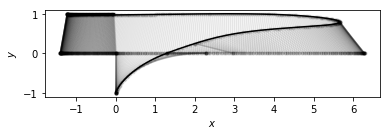

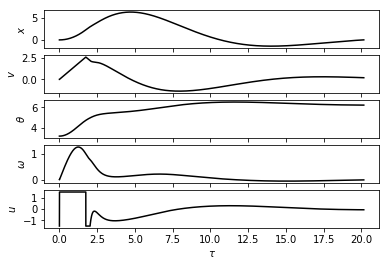

In [42]:
t = t[:n]
x = x[:n,:]
u = u[:n]
ax = plot_traj(x, arm=True, n=500)
ax = plot_states(t, x, u)

In [43]:
np.trapz(abs(u), t)

8.402765031581783

In [44]:
t[-1]

20.161219425891172